# Test

In [ ]:
from plots.plot_utils import load_pickle
from pathlib import Path
import os

experiment_home = Path("/home/scratch/yixiz/results/lump")
all_pkl = experiment_home.glob("**/*.pkl")

for pkl in all_pkl:
    print(pkl)
    try:
        data = load_pickle(pkl)
    except Exception as e:
        print(f"{pkl} can't load: {e}")

Text(0.5, 1.0, 'Test ECE vs Sharpness')

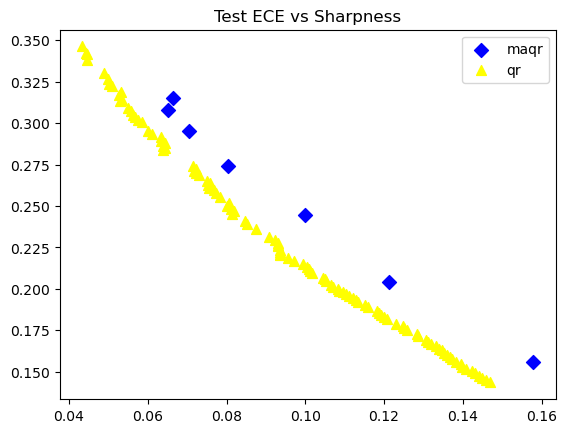

In [14]:
plt.scatter(pkl_maqr['te_ece_controlled'], pkl_maqr['te_sharp_score_controlled'], label='maqr', marker='D', color='blue', s=50)
plt.scatter(pkl_qr['te_ece_controlled'], pkl_qr['te_sharp_score_controlled'], label='qr', marker='^', color='yellow', s=50)
plt.legend()
plt.title('Test ECE vs Sharpness')


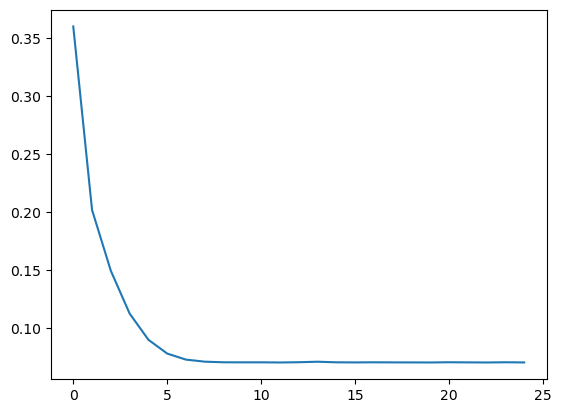

In [10]:
plt.plot(pkl_maqr['tr_loss_list'], label='maqr')

# Datasets

In [1]:
# transfer csv into space separated

with open('data/datasets/Features_TestSet.csv', 'r') as f:
    test_lines = f.readlines()

with open('data/datasets/Features_Variant_2.csv', 'r') as f:
    train_lines = f.readlines()

with open('data/datasets/facebook_train.txt', 'w') as f:
    for line in train_lines:
        f.write(' '.join(line.strip().split(',')) + '\n')

with open('data/datasets/facebook_test.txt', 'w') as f:
    for line in test_lines:
        f.write(' '.join(line.strip().split(',')) + '\n')


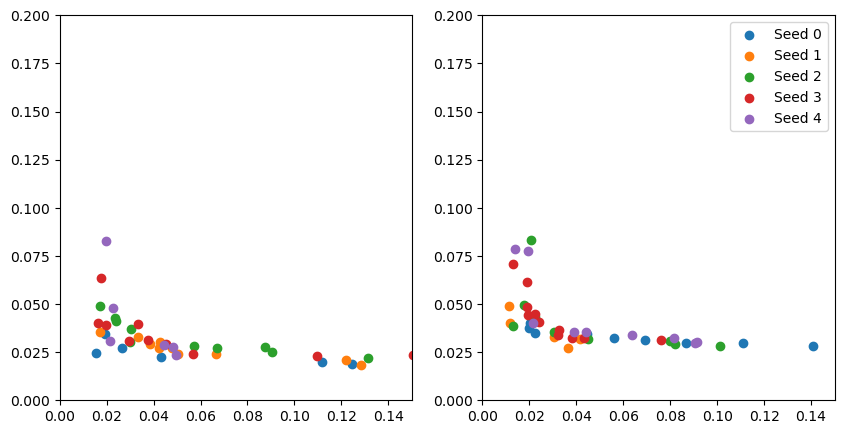

In [1]:
import matplotlib.pyplot as plt
import os
from plots.plot_utils import load_pickle
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
method = 'batch_cal'
hyper = 'nl-8_hs-256'
for i, method in enumerate(['batch_cal', 'batch_qr']):
    plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f"naval/{hyper}/naval_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace('-', '')}_0.pkl")
    plt_seeds = [plt_seed.replace("_0.pkl", f"_{i}.pkl") for i in range(5)]
    datas = [load_pickle(pkl) for pkl in plt_seeds]
    for j, data in enumerate(datas):
        axes[i].scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"Seed {j}")
        axes[i].set_xlim(0, 0.15)
        axes[i].set_ylim(0, 0.2)
plt.legend()

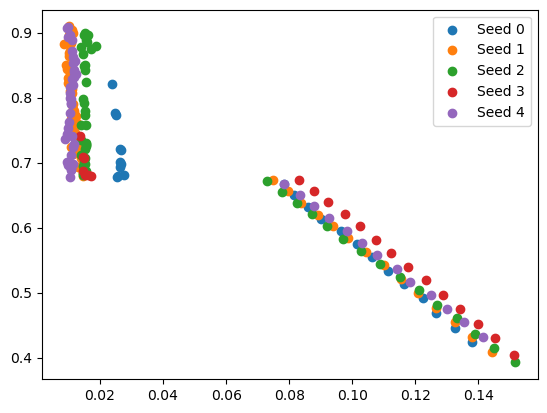

In [7]:

import matplotlib.pyplot as plt
import os
from plots.plot_utils import load_pickle
method = 'batch_qr'
plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f'naval/nl-1_hs-32/naval_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl')
plt_seeds = [plt_seed.replace("_0.pkl", f"_{i}.pkl") for i in range(5)]
datas = [load_pickle(pkl) for pkl in plt_seeds]
for i, data in enumerate(datas):
    plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"Seed {i}")
plt.legend()

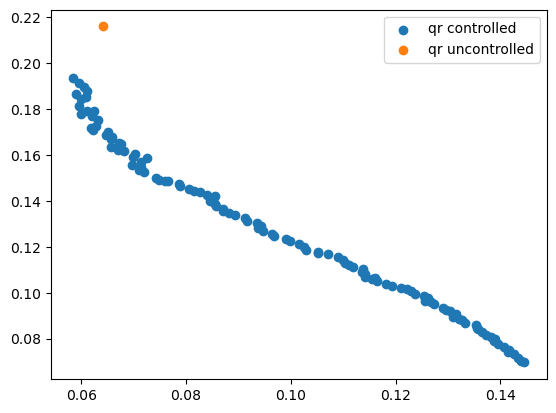

In [ ]:
from plots.plot_utils import load_pickle
batch_qr_pkl = 'boston_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
data = load_pickle(batch_qr_pkl)
import matplotlib.pyplot as plt
plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label='qr controlled')
plt.scatter(data['te_ece'], data['te_sharp_score'], label='qr uncontrolled')
plt.legend()

In [14]:
import numpy as np
def find_epoch_by_ece_sh(va_ece_list, va_sharp_list, target_ece, target_sharp):
    # exact match
    for epoch, (ece, sharp) in enumerate(zip(va_ece_list, va_sharp_list)):
        if np.isclose(ece, target_ece, atol=1e-3) and np.isclose(sharp, target_sharp, atol=1e-3):
            return epoch
    return -1


In [ ]:
from glob import glob
from plots.plot_utils import load_pickle
prefix = os.path.join(os.environ['SCRATCH'], 'results', 'full_wo_calipso')
pkls = glob(os.path.join(prefix, '**', '*.pkl'), recursive=True)
for pkl in pkls:
    data = load_pickle(pkl)
    va_ece_list = data['va_ece_list']
    va_sharp_list = data['va_sharp_list']
    va_ece_list_controlled = data['va_ece_controlled']
    va_sharp_list_controlled = data['va_sharp_score_controlled']
    for ece, sharp in zip(va_ece_list_controlled, va_sharp_list_controlled):
        epoch = find_epoch_by_ece_sh(va_ece_list, va_sharp_list, ece, sharp)
        if epoch == -1:
            print(f"Not found in {pkl} for ece {ece}, sharp {sharp}")

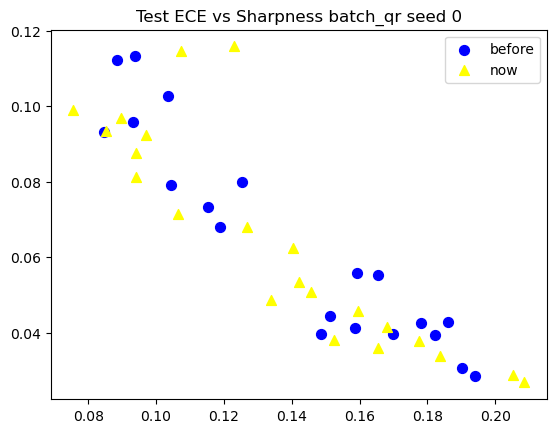

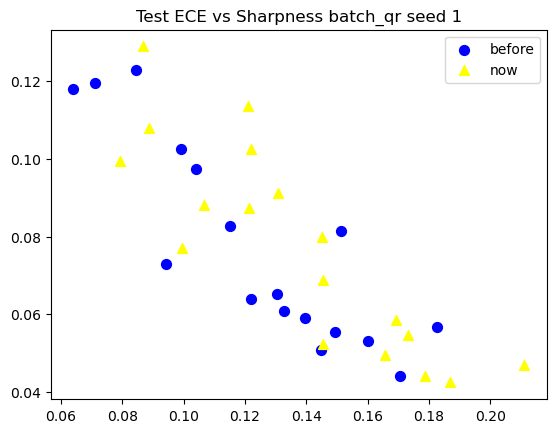

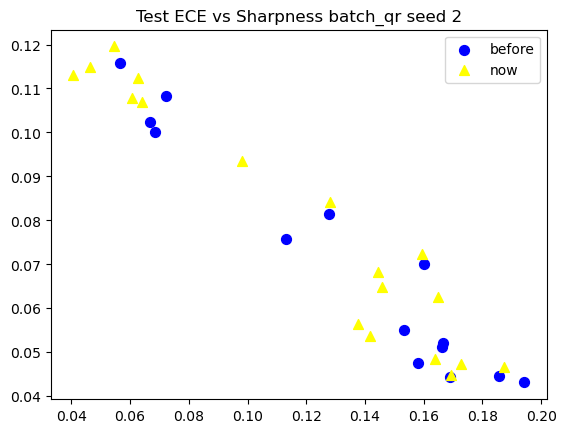

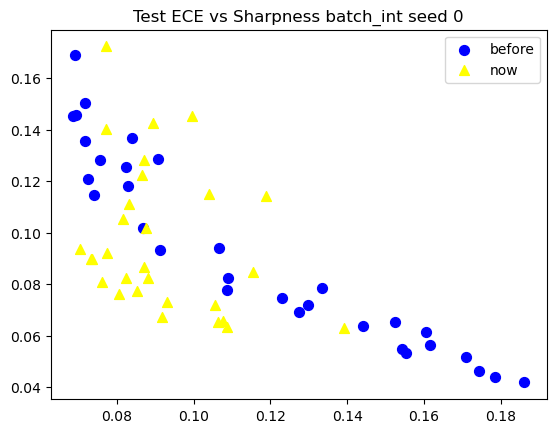

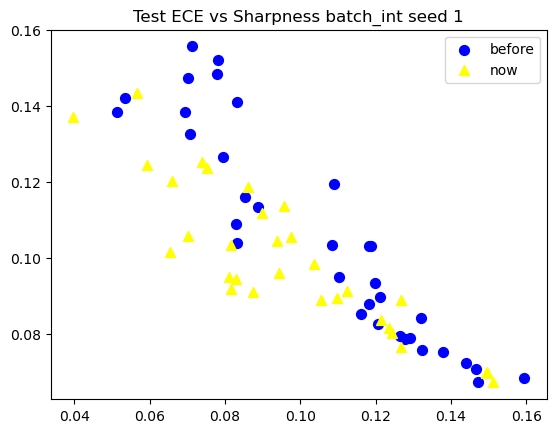

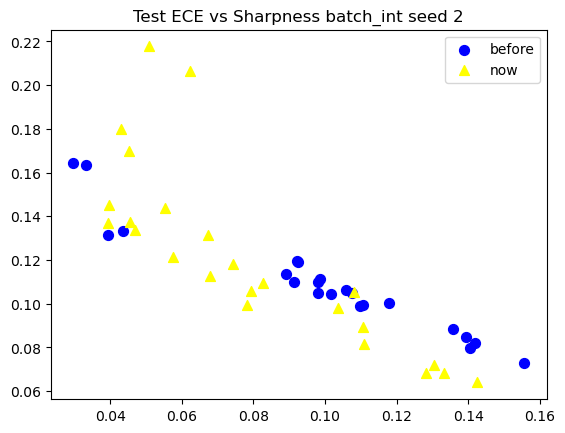

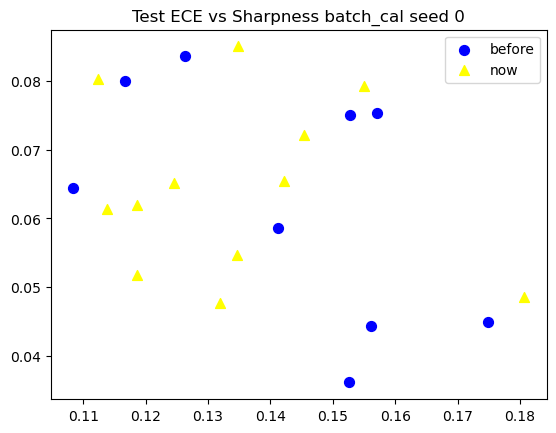

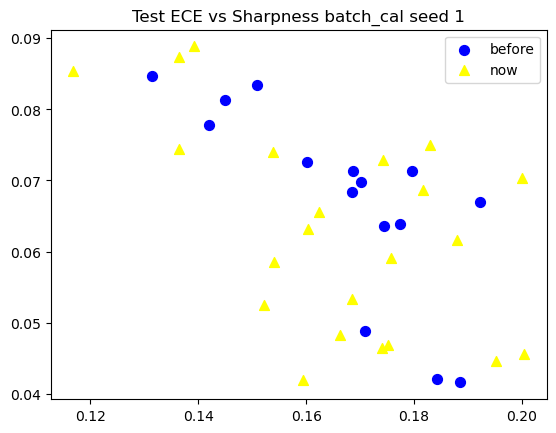

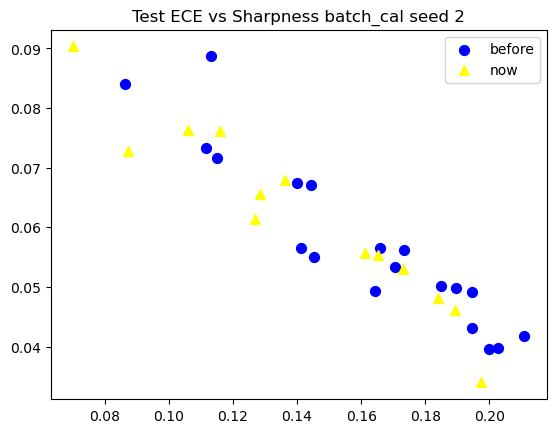

In [12]:
from plots.plot_utils import load_pickle
import os
hyper = 'nl-8_hs-256'
for method in ['batch_qr', 'batch_int', 'batch_cal']:
    for seed in range(3):
        prefix_before = os.path.join(os.environ['SCRATCH'], 'results', 'lump', 'boston', hyper)
        prefix_now = os.path.join(os.environ['SCRATCH'], 'results', 'full_wo_calipso', 'boston', hyper)
        pkl_before_change = os.path.join(prefix_before, f'boston_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace("-", "")}_{seed}.pkl')
        pkl_now = os.path.join(prefix_now, f'boston_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace("-", "")}_{seed}.pkl')
        data_before = load_pickle(pkl_before_change)
        data_now = load_pickle(pkl_now)

        te_ece_before = data_before['te_ece_controlled']
        te_sharp_before = data_before['te_sharp_score_controlled']

        te_ece_now = data_now['te_ece_controlled']
        te_sharp_now = data_now['te_sharp_score_controlled']

        import matplotlib.pyplot as plt

        plt.scatter(te_ece_before, te_sharp_before, label='before', marker='o', color='blue', s=50)
        plt.scatter(te_ece_now, te_sharp_now, label='now', marker='^', color='yellow', s=50)

        plt.legend()
        plt.title(f"Test ECE vs Sharpness {method} seed {seed}")
        plt.show()
        plt.close()

Text(0.5, 1.0, 'Validation ECE vs Sharpness')

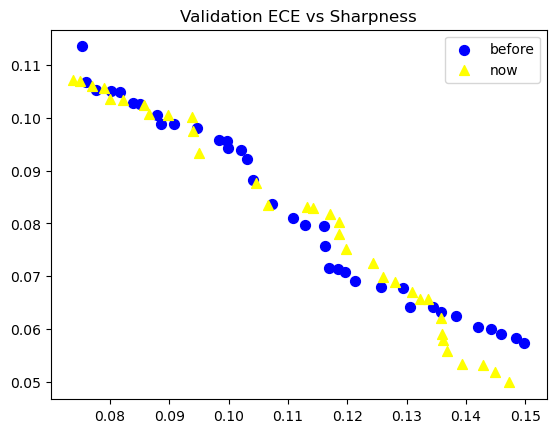

In [5]:
va_ece_before = data_before['va_ece_controlled']
va_sharp_before = data_before['va_sharp_score_controlled']

va_ece_now = data_now['va_ece_controlled']
va_sharp_now = data_now['va_sharp_score_controlled']

import matplotlib.pyplot as plt

plt.scatter(va_ece_before, va_sharp_before, label='before', marker='o', color='blue', s=50)
plt.scatter(va_ece_now, va_sharp_now, label='now', marker='^', color='yellow', s=50)

plt.legend()
plt.title('Validation ECE vs Sharpness')

Text(0.5, 1.0, 'telidation ECE vs Sharpness')

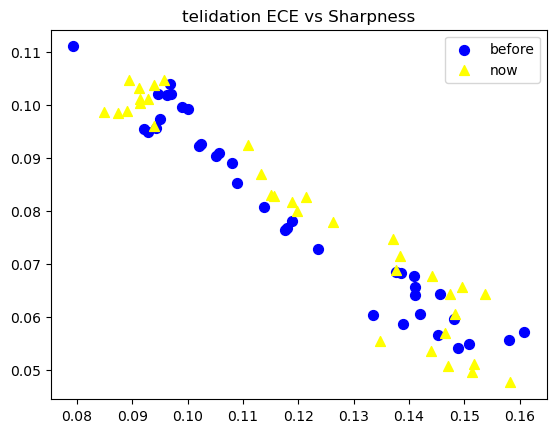

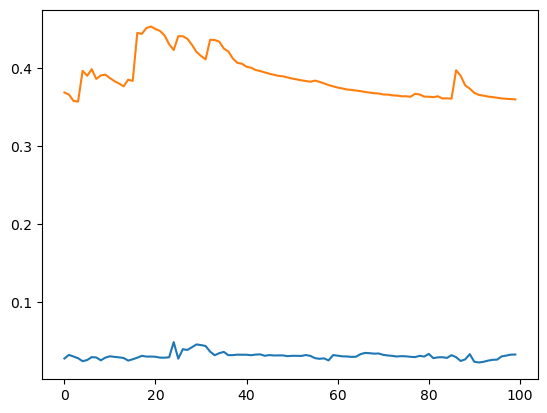

In [9]:
from plots.plot_utils import load_pickle

pkl_calipso = 'boston_losscalipso_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
data_cailpso = load_pickle(pkl_calipso)

import matplotlib.pyplot as plt

# plt.scatter(data_cailpso['va_ece_controlled'], data_cailpso['va_sharp_score_controlled'], label='calipso', marker='D', color='blue', s=50)
plt.plot(data_cailpso['va_ece_list'], label='calipso')
plt.plot(data_cailpso['va_sharp_list'], label='calipso sharpness')

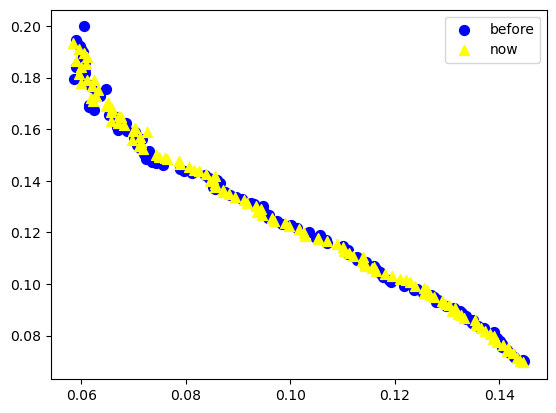

In [14]:
from plots.plot_utils import load_pickle
import os
import matplotlib.pyplot as plt

pkl_before_change = os.path.join(os.environ['SCRATCH'], 'results', 'lump', 'boston', 'nl-1_hs-32', 'boston_lossbatch_qr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl')
pkl_now = 'boston_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'

data_before = load_pickle(pkl_before_change)
data_now = load_pickle(pkl_now)

plt.scatter(data_before['te_ece_controlled'], data_before['te_sharp_score_controlled'], label='before', marker='o', color='blue', s=50)
plt.scatter(data_now['te_ece_controlled'], data_now['te_sharp_score_controlled'], label='now', marker='^', color='yellow', s=50)
plt.legend()



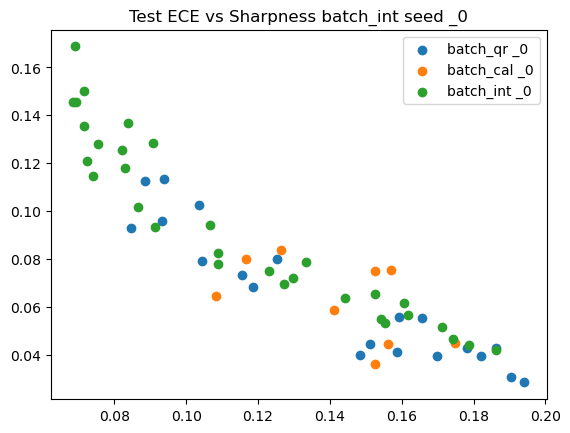

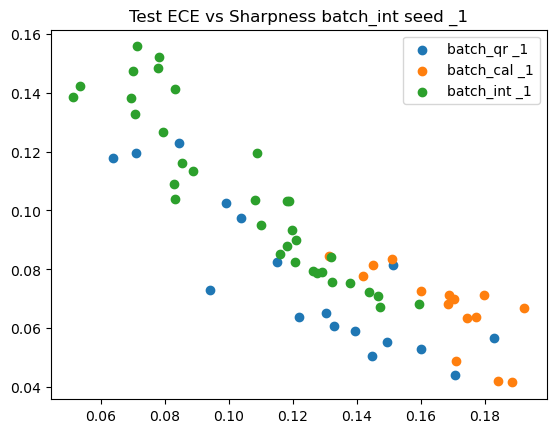

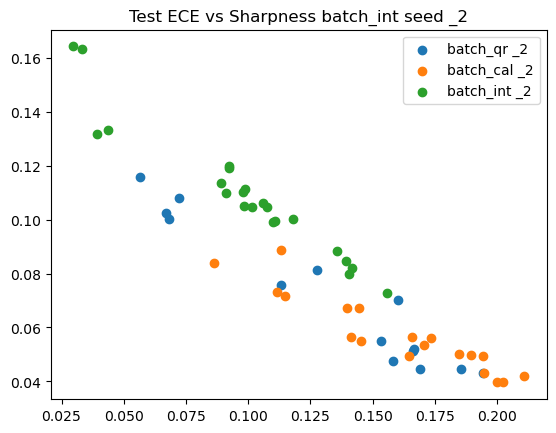

In [17]:
seeds = ['_0', '_1', '_2']

import matplotlib.pyplot as plt

import os

from plots.plot_utils import load_pickle

methods = ['batch_qr', 'batch_cal', 'batch_int']

for seed in seeds:
    for method in methods:
        hyper = 'nl-8_hs-256'
        plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f'boston/{hyper}/boston_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace("-", "")}{seed}.pkl')
        data = load_pickle(plt_seed)
        plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"{method} {seed}")
        plt.legend()
    plt.title(f'Test ECE vs Sharpness {method} seed {seed}')
    plt.show()
    plt.close()



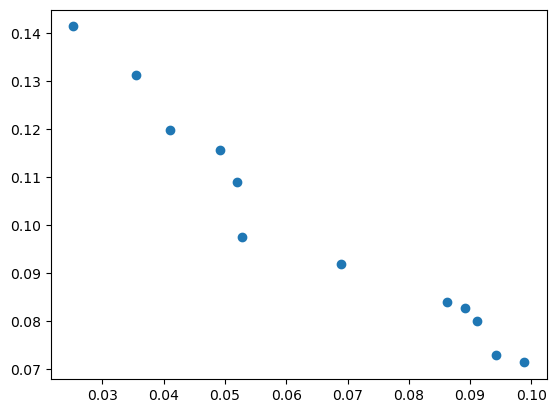

In [19]:
pareto_front = [(0.025228755548596382, 0.14136664497237844), (0.0354367196559906, 0.1312375292545692),
(0.040990300476551056, 0.11976797572064102), (0.0492255873978138, 0.11575049198838265),                       
(0.052030108869075775, 0.10890324466437508), (0.052818380296230316, 0.09761529279753597),                     
(0.06890473514795303, 0.09202769363143744), (0.08620321750640869, 0.08400635480480478), (0.08914240449666977, 
0.08269210904199054), (0.09108734130859375, 0.08012696240106194), (0.09423252195119858, 0.07301722973765708), 
(0.09883146733045578, 0.07144077588213854)]
import matplotlib.pyplot as plt
plt.scatter(*zip(*pareto_front))

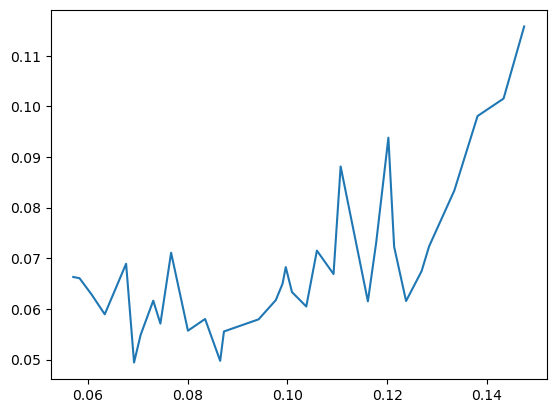

In [9]:
from plots.plot_utils import load_pickle

cali_boston_default_pkl = '/home/scratch/yixiz/results/full_wo_calipso/boston/default/boston_lossbatch_cal_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_2.pkl'
data = load_pickle(cali_boston_default_pkl)

import matplotlib.pyplot as plt

plt.plot(data['va_ece_controlled'], data['te_ece_controlled'], label='ece controlled')

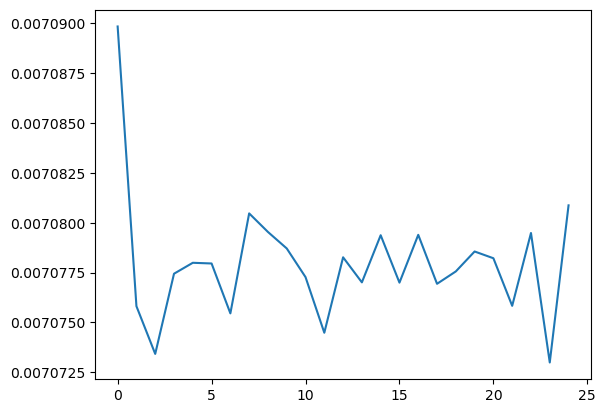

In [14]:
from plots.plot_utils import load_pickle

maqr_fusion_pkl = '/home/scratch/yixiz/results/lump/fusion/nl-8_hs-256/facebook_lossmaqr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_2.pkl'
data = load_pickle(maqr_fusion_pkl)

import matplotlib.pyplot as plt
plt.plot([tr.cpu() for tr in data['tr_loss_list']])

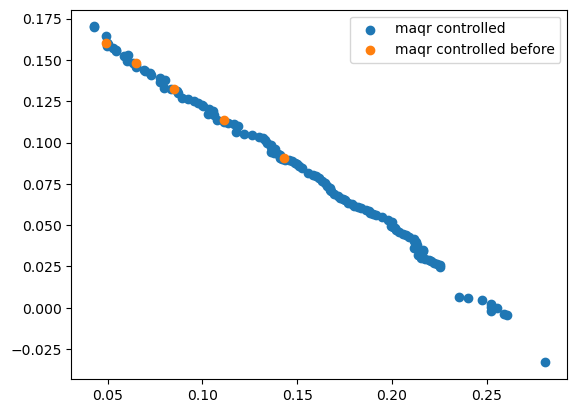

In [ ]:
from plots.plot_utils import load_pickle
maqr_boston_pkl = 'boston_lossmaqr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
maqr_boston_pkl_before = '/home/scratch/yixiz/results/lump/boston/nl-1_hs-32/boston_lossmaqr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
data = load_pickle(maqr_boston_pkl)
data_before = load_pickle(maqr_boston_pkl_before)

import matplotlib.pyplot as plt

plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label='maqr')
plt.scatter(data_before['te_ece_controlled'], data_before['te_sharp_score_controlled'], label='maqr before')

plt.legend()

# Cherry-pick

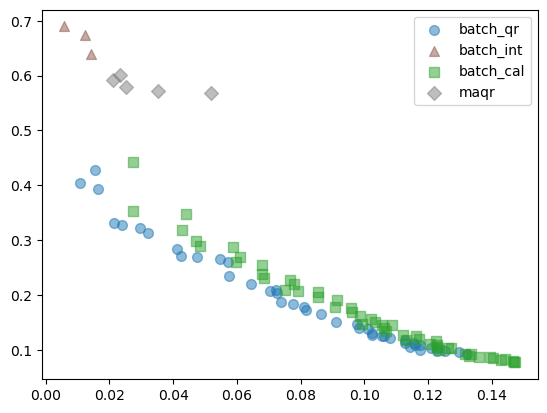

In [15]:
seed = 1
dataset = 'protein'
hyper = 'nl-8_hs-256'
# methods = ['batch_qr', 'batch_int', 'batch_cal', 'maqr', 'calipso']
methods = ['batch_qr', 'batch_int', 'batch_cal', 'maqr']
import matplotlib.pyplot as plt
from plots.plot_utils import load_pickle, METHOD_COLORS, METHOD_MARKERS
import os
for method in methods:
    pkl = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f"{dataset}/{hyper}/{dataset}_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace('-', '')}_{seed}.pkl")
    data = load_pickle(pkl)
    plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=method, marker=METHOD_MARKERS[method], color=METHOD_COLORS[method], s=50, alpha=0.5)
plt.legend()

